<a href="https://colab.research.google.com/github/GallegoLab/PyF2F/blob/main/PyF2F_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to PyF2F <br>
In this tutorial, we provide the code to run:

1. **Image Registration** to correct for the chromatic shift in the two-channel images during the acquisition.

2. **Distance Estimation** workflow to determine the distance between two fluorescent markers.

This notebook runs through an `example` dataset provided in the [GitHub](https://github.com/GallegoLab/PyF2F). <br><br>
For more details, checkout our [GitHub](https://github.com/GallegoLab/PyF2F).

In [ ]:
#@title Install PyF2F with Python3.7

#@markdown PyF2F needs to be installed with Python-3.7.

#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left to download and install PyF2F software
#@markdown in this Colab notebook.

#@markdown **Note**: This installs the software on the Colab
#@markdown notebook in the cloud and not on your computer.
%env PYTHONPATH =
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_23.1.0-1-Linux-x86_64.sh
! chmod +x Miniconda3-py37_23.1.0-1-Linux-x86_64.sh
! bash ./Miniconda3-py37_23.1.0-1-Linux-x86_64.sh -b -f -p /usr/local/
!conda install --channel defaults conda python=3.7 --yes


# Clone github and install requirements to run PyF2F
!git clone https://github.com/GallegoLab/PyF2F
%cd PyF2F
!pip install -r requirements.txt
!conda install ipykernel --yes
!pip install protobuf==3.20.*  # to make tensorflow work properly
!pip install zenodo-get        # to get zenodo weights.zip file



## Running PyF2F

Please set the `parameters` required to run the **image registration**
and **distance estimation** workflows. Then hit `Runtime` -> `Run after`.<br>

You can also run the cells individually by pressing the *Play* button on the left. <br>

You can find a detailed explanation about PyF2F's workflow and a step-by-step tutorial in the [GitHub](https://github.com/GallegoLab/PyF2F).

In [ ]:
#@title Set parameters to run PyF2F ⬇️
#@markdown Please set the `parameters` required to run the **image registration**
#@markdown and **distance estimation** workflows:
#@markdown ###**Parameters:**
# , then hit `Runtime` -> `Run all`
import os
if not os.getcwd() == "/content/PyF2F/scripts_colab/":
  os.chdir("/content/PyF2F/scripts_colab/")
job_name = 'short_example'          #@param ['short_example', 'full_example'] {type:"string"}
pixel_size = 64.5                  #@param [64.5, 110] {type:"raw"}
# Define spot diameter
if pixel_size == 64.5:
  spot_diameter = int(11)
elif pixel_size == 110:
  spot_diameter = int(7)

# spot detection: sort spots below this percentile of intensity
percentile = 99.8                  #@param {type:"raw"}
# linking: link spots from ch1-ch2 channels separated by this cutoff in px
max_displacement = 3               #@param [1, 2, 3, 4, 5]{type:"raw"}

#@markdown **Image Registration:**
beads_head = '*.tif'               #@param {type:"string"}
beads_reg_dir = 'reg'               #@param {type:"string"}
beads_test_dir = 'test'             #@param {type:"string"}
# Create directories for output
out_reg_dir = 'out_reg'         #@param {type:"string"}
out_test_dir = 'out_test'       #@param {type:"string"}
# Bead detection based on light properties
# spot detection: sort spots with a mass above this threshold (range 0-1).
min_mass = 0.01                    #@param {type:"raw"}
# spot detection: sort spots with a mass below this threshold (range 0-1).
max_mass =0.95                     #@param {type:"raw"}

#@markdown **Distance Estimation :**
rolling_ball_radius = 70                    #@param {type:"raw"}
median_filter = 10                          #@param {type:"raw"}
contour_cutoff = 13                         #@param {type:"raw"}
neigh_cutoff = 9                            #@param {type:"raw"}
kde_cutoff = 0.5                            #@param {type:"raw"}
gaussian_cutoff = 0.35                      #@param {type:"raw"}
mle_cutoff = 0.66                           #@param {type:"raw"}

#@markdown Select the following checkbox to perform a the image registration with a
#@markdown global or local affine transformation.

# Select between 'global' or 'local' registration
global_registration = True #@param {type:"boolean"}
local_registration = False #@param {type:"boolean"}
# local registration: max distance in px for nearest-neighbour search
search_range = 2000 // pixel_size  #local registration: max distance in px for nearest-neighbour search
min_fiducials = 10                 #local registration: minimum number of fiducial markers to correct locally

#@markdown
#@markdown
#@markdown You may want to track the spot detection and selection along the
#@markdown process. The following checkbox will generate HTML outputs for each
#@markdown step of the process (will run slower).
do_html_plots = True #@param {type:"boolean"}

#@markdown
#@markdown


# Paths to directories where Beads_reg and Beads_test
path_beads_reg = f"../{job_name}/input/{beads_reg_dir}/"
path_beads_test = f"../{job_name}/input/{beads_test_dir}/"

path_output_reg = f"../{job_name}/input/{out_reg_dir}/"
path_output_test = f"../{job_name}/input/{out_test_dir}/"

if not os.path.exists(path_output_reg):
    os.mkdir(path_output_reg)

if not os.path.exists(path_output_test):
    os.mkdir(path_output_test)

# Get weights.zip file from Zenodo repo with record ID 3598690
!zenodo_get -r 3598690
!unzip weights.zip
!rm weights.zip



In [ ]:
#@title Run Image Registration protocol
#@markdown Generating registration map to correct for the chromatic aberration
#@markdown between channel 1 (C1-RFP) and channel 2 (C2-GFP). <br><br>
#@markdown Synthetic bead (TetraSpeck) of 100 nm are imaged in the two channels
#@markdown to create the registration map and to compute the affine
#@markdown transformation matrix that corrects the C1-bead-centroid coordinates for the
#@markdown chromatic aberration using C2-bead-centroid coordinates as reference.
#@markdown
#@markdown

#@markdown Select the following checkbox to download results as a ZIP file to
#@markdown your local computer.
download_zip = True #@param {type:"boolean"}

if global_registration:
  if do_html_plots:
    !python3 PyF2F_image_registration.py -bri $path_beads_reg -bti $path_beads_test -bro $path_output_reg -bto $path_output_test --name $beads_head -px $pixel_size -sd $spot_diameter -pc $percentile --min_mass $min_mass --max_mass $max_mass -l $max_displacement --global --plot
  else:
    !python3 PyF2F_image_registration.py -bri $path_beads_reg -bti $path_beads_test -bro $path_output_reg -bto $path_output_test --name $beads_head -px $pixel_size -sd $spot_diameter -pc $percentile --min_mass $min_mass --max_mass $max_mass -l $max_displacement --global
if local_registration:
  if do_html_plots:
    !python3 PyF2F_image_registration.py -bri $path_beads_reg -bti $path_beads_test -bro $path_output_reg -bto $path_output_test --name $beads_head -px $pixel_size -sd $spot_diameter -pc $percentile --min_mass $min_mass --max_mass $max_mass -l $max_displacement -s $search_range --min_fiducials $min_fiducials --plot
  else:
    !python3 PyF2F_image_registration.py -bri $path_beads_reg -bti $path_beads_test -bro $path_output_reg -bto $path_output_test --name $beads_head -px $pixel_size -sd $spot_diameter -pc $percentile --min_mass $min_mass --max_mass $max_mass -l $max_displacement -s $search_range --min_fiducials $min_fiducials

# ========================
# Download Results as ZIP
# ========================

if download_zip:
  print("Downloading registration.zip file")
  from google.colab import files
  !zip -r /content/PyF2F/$job_name/input/registration.zip /content/PyF2F/$job_name/input/$out_test_dir
  files.download(f'/content/PyF2F/{job_name}/input/registration.zip')

In [ ]:
#@title Plot: Distance distribution and XY offset
#@markdown Plotting the distance distribution between beads' centroid coordinates
#@markdown in the two channels (C1-RFP and C2-GFP) before and after the chromatic
#@markdown aberration correction (left). The offset in the X (center) and
#@markdown Y (right) axis after chromatic aberration correction is plot.

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# ======
# PLOTS
# ======
# Read images
beads_distance_distribution = mpimg.imread(path_output_test + "distance_distribution_final.png")
shift_x = mpimg.imread(path_output_test + "distance_x_offset.png")
shift_y = mpimg.imread(path_output_test + "distance_y_offset.png")

# Display images
fig, ax = plt.subplots(1,3, figsize=(20, 10))

ax[0].imshow(beads_distance_distribution)
ax[0].set_title("Beads's C1-C2 Distance Distribution\nBefore vs After Affine Transformation")
ax[0].axis('off')
ax[1].imshow(shift_x)
ax[1].set_title("X axis offset")
ax[1].axis('off')
ax[2].imshow(shift_y)
ax[2].set_title("Y axis offset")
ax[2].axis('off')
plt.tight_layout()


In [ ]:
#@title Run Distance Estimation Workflow
#@markdown This section runs over the PyF2F workflow dedicated to:  <br> <br>
#@markdown 1- **Pre-process PICT images** (Background subtraction) <br>
#@markdown 2- **Spot-pair detection** (centroid (x,y) detection and C1-C2 linking) <br>
#@markdown 3- **Spot-pair filtering**: <br>
#@markdown *   Isolated spot-pairs close to the cell contour
#@markdown *   High-quality spot-pairs
#@markdown *   In-focus spot-pairs
#@markdown
#@markdown 4- **Outlier Rejection (MLE) and Distance estimation** <br> <br>
#@markdown MLE = Maximum Likelihood Estimation
#@markdown
#@
#@markdown Select the following checkboxes to run specific workflow steps
#@markdown or `all` the steps.
image_pre_processing = True #@param {type:"boolean"}
spot_pair_detection = True #@param {type:"boolean"}
select_close_to_contour = True #@param {type:"boolean"}
select_high_quality = True #@param {type:"boolean"}
select_in_focus = True #@param {type:"boolean"}
distance_estimation = True #@param {type:"boolean"}


### 1 Image Pre-processing



In [ ]:

if image_pre_processing:
  if do_html_plots:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --dirty --option pp
  else:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --option pp

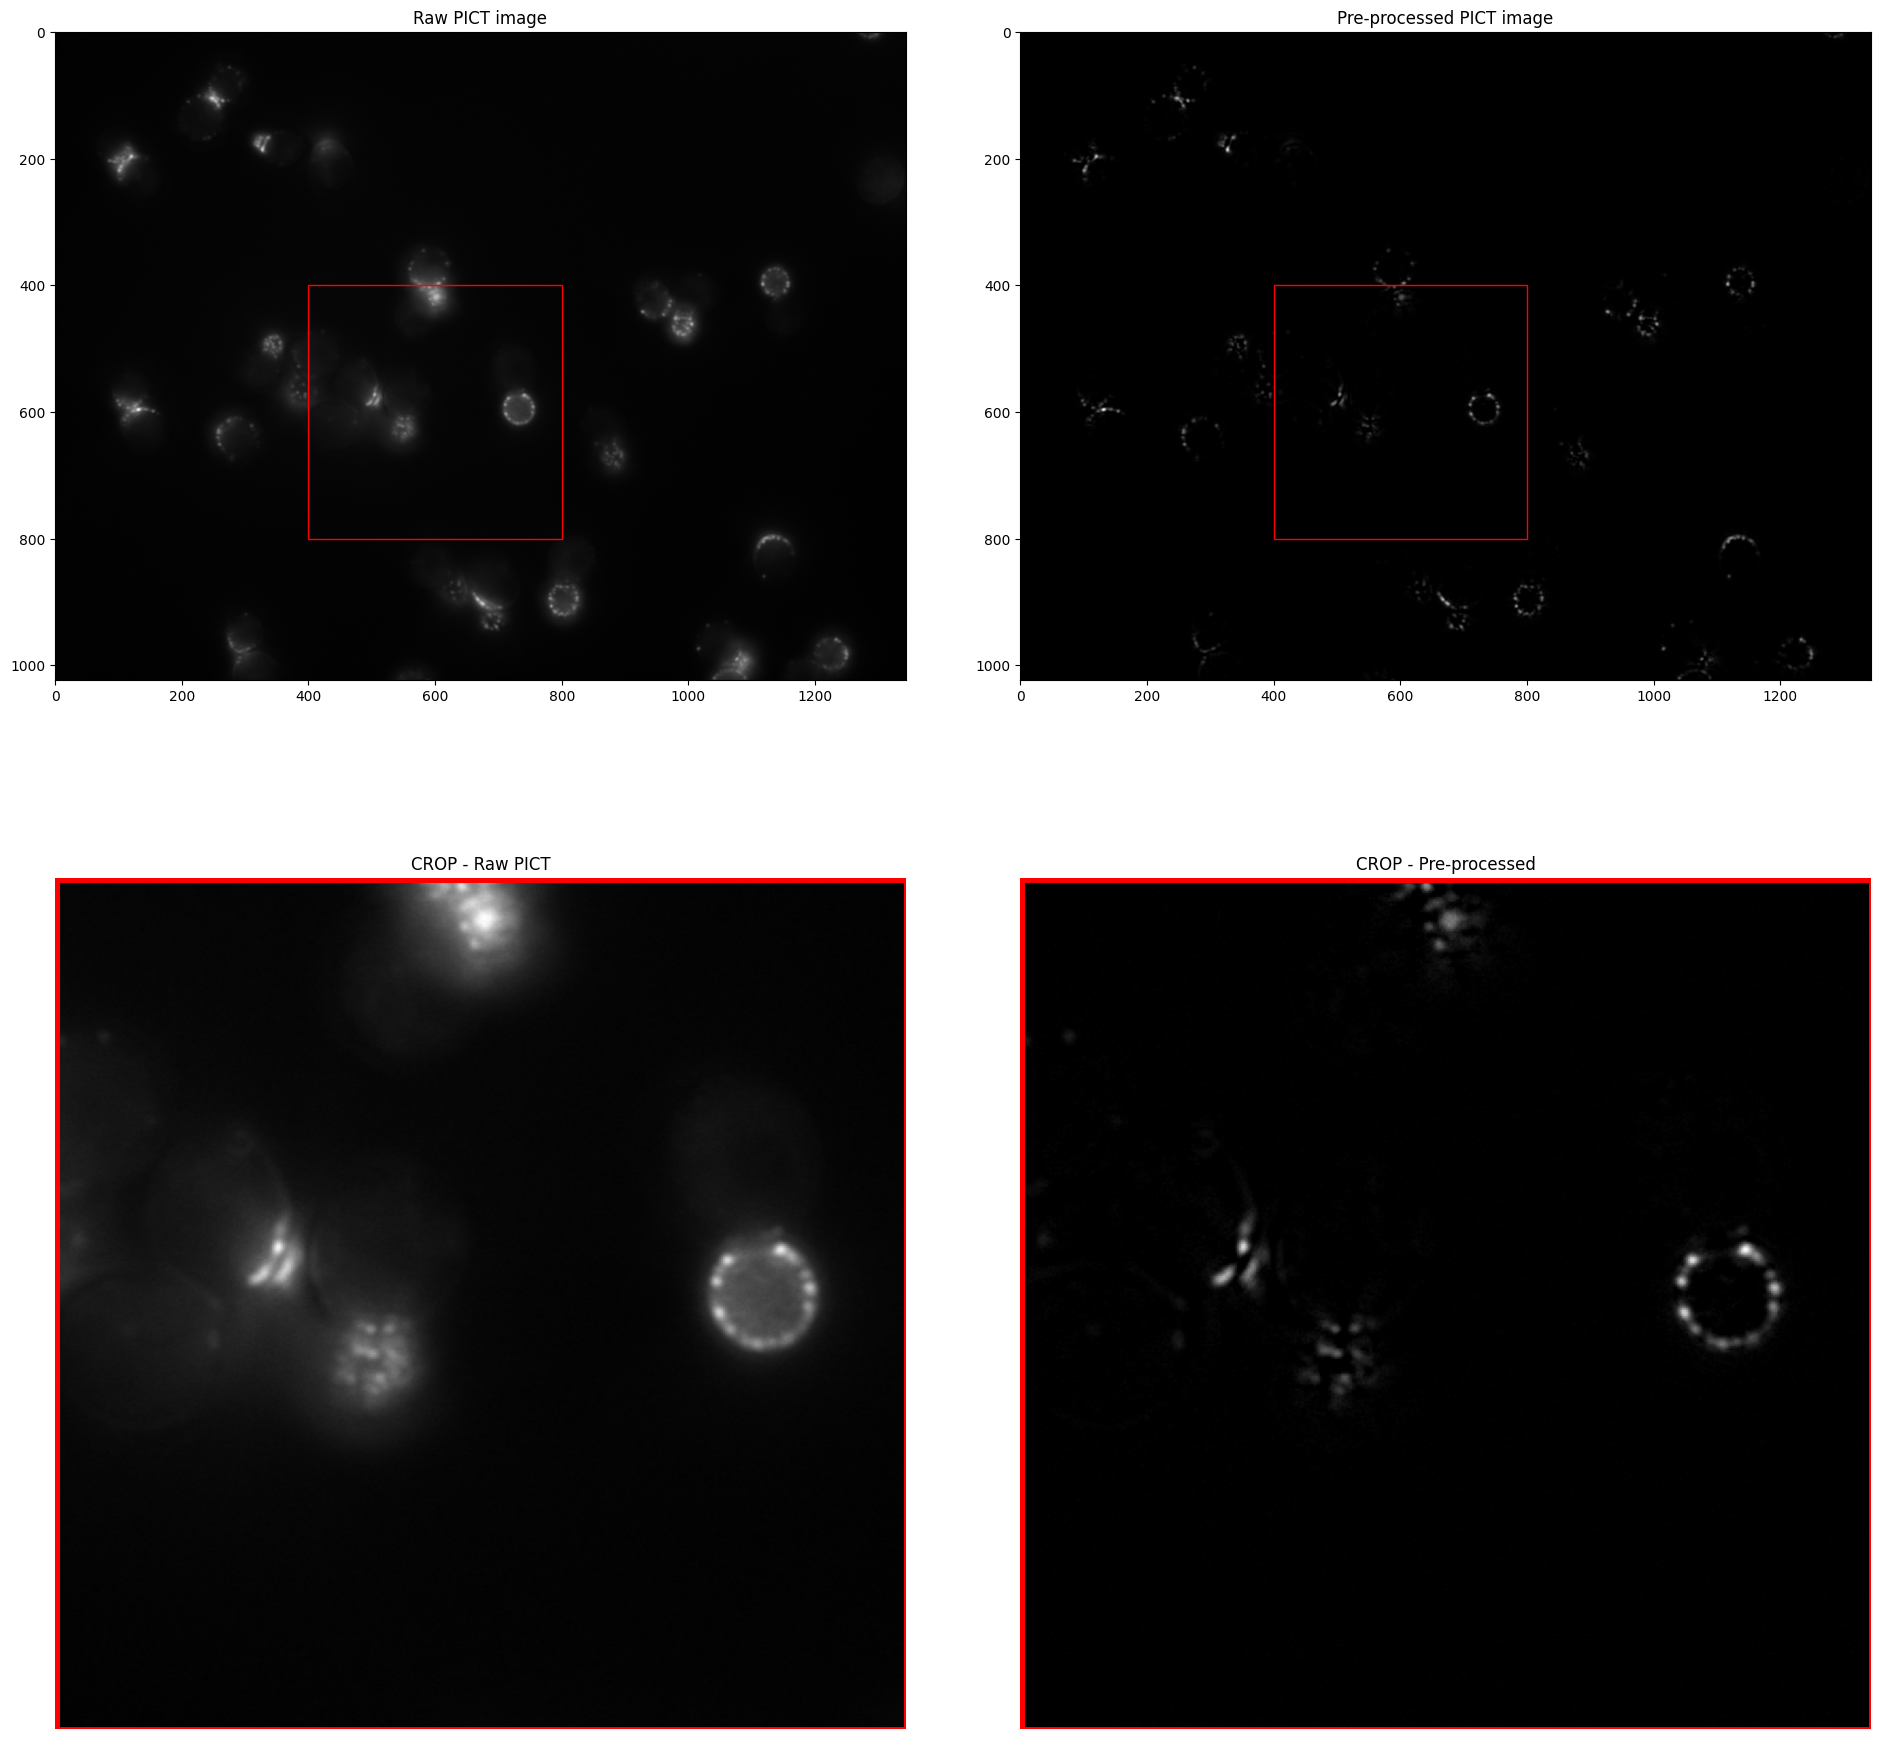

In [ ]:
#@title Plot: Image Pre-processing
if image_pre_processing:
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  import matplotlib.patches as patches
  import glob
  from skimage import io
  %matplotlib inline
  # ============================
  # PLOT EXAMPLE PRE-PROCESSING
  # ============================
  # Read images
  raw_images = sorted(glob.glob(f'../{job_name}/input/pict_images/*.tif'))
  pp_images = sorted(glob.glob(f'../{job_name}/output/images/imageMD*.tif'))
  example_PICT_image = io.imread(raw_images[0])
  example_pp_image = io.imread(pp_images[0])

  # Divide all values by 65535 so we can display the image using matplotlib
  example_PICT_image = example_PICT_image / 65535
  example_pp_image = example_pp_image / 65535
  # Create a Rectangle patch
  rect_1 = patches.Rectangle((400, 400), 400, 400, linewidth=1, edgecolor='r',
                          facecolor='none')
  rect_2 = patches.Rectangle((400, 400), 400, 400, linewidth=1, edgecolor='r',
                          facecolor='none')
  rect_1_crop = patches.Rectangle((0, 0), 400, 400, linewidth=5, edgecolor='r',
                          facecolor='none')
  rect_2_crop = patches.Rectangle((0, 0), 400, 400, linewidth=5, edgecolor='r',
                          facecolor='none')
  fig, ax = plt.subplots(2, 2, figsize=(20, 20))
  #ax[0][0].axis('off')
  ax[0][0].set_title("Raw PICT image")
  ax[0][0].imshow(example_PICT_image[0], cmap=plt.cm.gray)
  #ax[0][1].axis('off')
  ax[0][1].set_title("Pre-processed PICT image")
  ax[0][1].imshow(example_pp_image[0], cmap=plt.cm.gray)
  # Add the patch to the Axes
  ax[0][0].add_patch(rect_1)
  ax[0][1].add_patch(rect_2)

  ax[1][0].axis('off')
  ax[1][0].set_title("CROP - Raw PICT")
  ax[1][0].imshow(example_PICT_image[0][400:800, 400:800], cmap=plt.cm.gray)
  ax[1][1].axis('off')
  ax[1][1].set_title("CROP - Pre-processed")
  ax[1][1].imshow(example_pp_image[0][400:800, 400:800], cmap=plt.cm.gray)
  ax[1][0].add_patch(rect_1_crop)
  ax[1][1].add_patch(rect_2_crop)
  plt.tight_layout(pad=5.0)

### 2 Spot-Pair Detection, Linking and Affine Transformation of C1-coordinates

In [ ]:
if spot_pair_detection:
  if global_registration:
    if do_html_plots:
      !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --dirty --option spt,warping
    else:
      !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --option spt,warping
  if local_registration:
    if do_html_plots:
      !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --local_transformation --dirty --option spt,warping
    else:
      !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --local_transformation --option spt,warping

Using TensorFlow backend.


Total Initial W1 Detected spots: 327

Total Initial W2 Detected spots: 378

Total Final Paired spots: 171



Total Process time: 20.082 s



#######################
Done!

Have a good day :-)
#########################




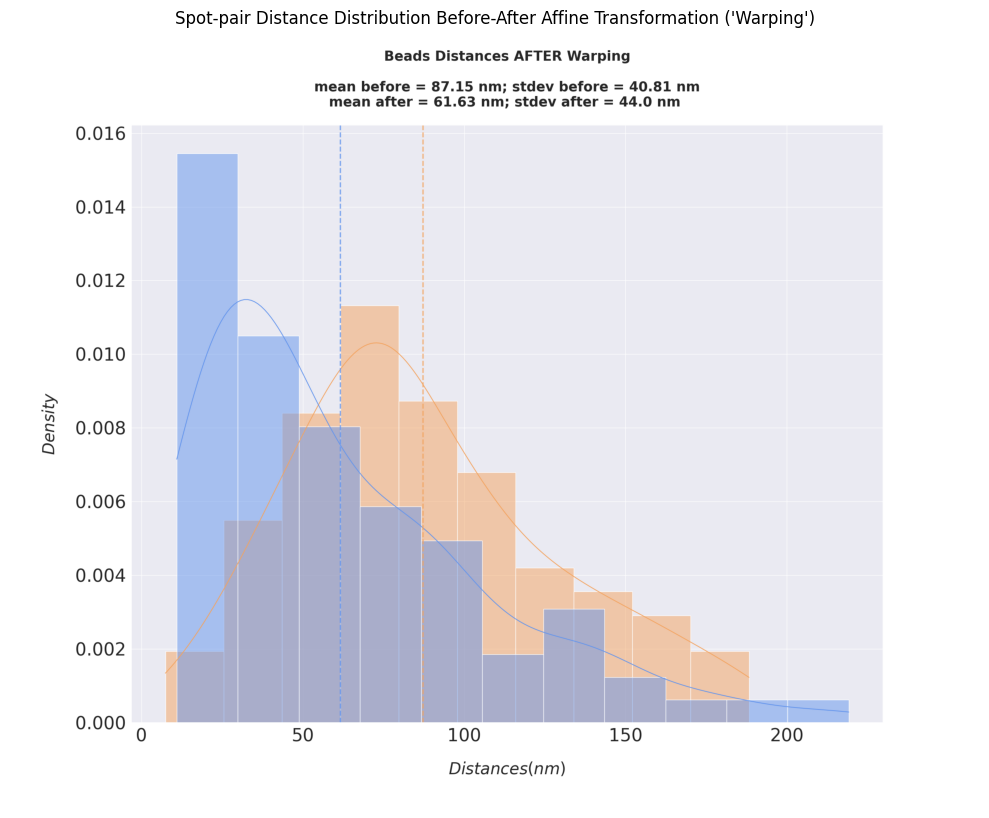

In [ ]:
#@title Interactive Plot: Spot-Pair Detection-Linking-Transformation
#@markdown Plotting background subtracted image with spot-pairs detected
#@markdown in channel 1 (red fluorescent signal - magenta - squares) and channel 2
#@markdown (green fluorescent signal - green - circles). Channel 1 coordinates
#@markdown corrected for the chromatic aberration (affine transformed) are shown
#@markdown as yellow stars.
#@markdown
#@markdown
#@markdown <b>Interactive Plot</b>: Use the mouse to select a square region to
#@markdown zoom-in in a particular spot-pair. You can show/hide labels by clicking
#@markdown in the legend (right). Double-click on the image to zoom-out.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import IFrame
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from skimage import io

ndimage = io.imread(f"../{job_name}/output/images/image_01.tif")[1, :, :]
coords_W1 = np.loadtxt(f"../{job_name}/output/spots/detected_spot_01_W1.csv",
                       delimiter="\t", usecols=[0, 1], skiprows=1)
coords_W1_warped = np.loadtxt(f"../{job_name}/output/spots/detected_spot_01_W1_warped.csv",
                              delimiter="\t", usecols=[0, 1], skiprows=1)
coords_W2 = np.loadtxt(f"../{job_name}/output/spots/detected_spot_01_W2.csv",
                       delimiter="\t", usecols=[0, 1], skiprows=1)

# Plot initial coordinates of W1 and W2 and a line indicating pairs
foo_note = f"<br>Number of Linked spots: {len(coords_W1)} Spot-pairs<br>" \
           f"Max separation C1 (RFP) - C2 (GFP): {max_displacement} pixels<br>" \
           f"Percentile: {percentile}%<br><br><br> " \
           "Use the mouse to select a region to zoom-in. Double-click on " \
           "the image to zoom-out."
fig = px.imshow(ndimage, color_continuous_scale='gray',
              title=f"<b>Interactive Plot<br>" \
              f"Image 01 - Spot Linking</b><br>{foo_note}",
                width=1024, height=1024, zmin=100, zmax=1000)
                # contrast_rescaling='minmax')
fig.update_layout(coloraxis_showscale=False)  # to hide color bar
if coords_W1.ndim == 2 and coords_W1_warped.ndim == 2 and coords_W2.ndim == 2:
  fig.add_scatter(x=coords_W2[:, 1], y=coords_W2[:, 0],
                  mode="markers",
                  marker_symbol="circle-dot",
                  marker=dict(color="green", size=10,
                              line=dict(width=2,
                                        color='green')),
                  name="prey-GFP centroid coordinates",
                  opacity=0.7)
  fig.add_scatter(x=coords_W1[:, 1], y=coords_W1[:, 0],
                  mode="markers",
                  marker_symbol="square-dot",
                  marker=dict(color="red", size=10,
                              line=dict(width=2,
                                        color='magenta')),
                  name="anchor-RFP centroid coordinates",
                  opacity=0.7)

# Draw lines between W2 - W1 before warping to see link
for i in range(len(coords_W1)):
    y1, y1_warped, y2 = coords_W1[i][1], coords_W1_warped[i][1], coords_W2[i][1]
    x1, x1_warped, x2 = coords_W1[i][0], coords_W1_warped[i][0], coords_W2[i][0]
    fig.add_trace(go.Scatter(x=[y1, y2], y=[x1, x2],
                              mode="lines",
                              line=go.scatter.Line(color="black"),
                              name="{}".format(i), showlegend=False))
    fig.add_trace(go.Scatter(x=[y1_warped, y2], y=[x1_warped, x2],
                              mode="lines",
                              line=go.scatter.Line(color="purple"),
                              name="{}".format(i), showlegend=False))

# PLOT WARPED COORDS IN IMAGE AFTER TRANSFORMATION
fig.add_scatter(x=coords_W1_warped[:, 1], y=coords_W1_warped[:, 0],
                mode="markers",
                marker_symbol="x-dot",
                marker=dict(color="orange", size=10,
                            line=dict(width=2,
                                      color='orange')),
                name="prey-GFP affine transformed centroid coordinates",
                opacity=0.7)
fig.show()

# ======
# PLOTS
# ======
# Read images
distance_after_aff_transformation = mpimg.imread(f"../{job_name}" \
                                                 "/output/figures" \
                                                 "/spot_detection/" \
                                                 "distances_after_warping.png")

# Display images
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(distance_after_aff_transformation)
ax.set_title("Spot-pair Distance Distribution Before-After Affine Transformation ('Warping')")
ax.axis('off')
plt.tight_layout()


### 3 Spot-pair filtering

In [ ]:
#@title 3-1 Spot-pair filtering: Isolated & Close-to-contour
if select_close_to_contour:
  if do_html_plots:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --dirty --option segment
  else:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --option segment

In [ ]:
#@title Interactive Plot: Isolated & Close-to-contour Spot-Pair Selection
#@markdown Plotting isolated spot-pairs (magenta-green) that are close to the
#@markdown cell contour
#@markdown
#@markdown <b>Interactive Plot</b>: Use the mouse to select a square region to
#@markdown zoom-in in a particular spot-pair. You can show/hide labels by clicking
#@markdown in the legend (right). Double-click on the image to zoom-out.
%matplotlib inline
from IPython.display import IFrame
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


ndimage = io.imread(f"../{job_name}/output/segmentations/masks/contour_mod_01.tif").astype("uint8")
data_W1 = pd.read_csv(f"../{job_name}/output/results/segmentation/detected_seg_01_W1.csv",
                       delimiter="\t")
data_W2 = pd.read_csv(f"../{job_name}/output/results/segmentation/detected_seg_01_W2.csv",
                       delimiter="\t")

# Plot initial coordinates of W1 and W2 and a line indicating pairs
foo_note = f"<br>* Number of Selected spots: {len(data_W1)} spot-pairs"  \
           f"<br>* Max. closest-neighbour distance: {neigh_cutoff} pixels"   \
           f"<br>* Max. distance-to-cell-conotur: {contour_cutoff} pixels <br><br>"   \
           "Use the mouse to select a region to zoom-in. Double-click on "  \
           "the image to zoom-out."
img_contour = (ndimage > 0).astype("uint8")
fig = px.imshow(img_contour, color_continuous_scale='gray',
              title=f"<b>Interactive Plot: " \
              f"Image 01 - Isolated Spot-Pair Close-to-Contour</b><br>{foo_note}",
                width=1024, height=1024)
fig.update_layout(coloraxis_showscale=False)  # to hide color bar

fig.add_scatter(x=data_W1["y"], y=data_W1["x"],
                               mode="markers",
                               marker=dict(color="magenta", size=7),
                               name="selected anchor-RFP",
                               hovertemplate=
                               '<b>x: %{x: }</b><br>'
                               '<b>y: %{y: } <b><br>')

fig.add_scatter(x=data_W2["y"], y=data_W2["x"],
                               mode="markers",
                               marker=dict(color="green", size=7),
                               name="selected prey-GFP",
                               hovertemplate=
                               '<b>x: %{x: }</b><br>'
                               '<b>y: %{y: } <b><br>')

fig.show()

In [ ]:
#@title 3-2 Spot-pair filtering: High-quality
if select_high_quality:
  if do_html_plots:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --dirty --option kde
  else:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --option kde

In [ ]:
#@title Plot: High-quality Spot-pair Selection
#@markdown Plotting spot-pairs sharing similar properties in brightness
#@markdown (integrated intensity) and shape (eccentricity) with a 2D-Kernel
#@markdown Density Estimation (2D-KDE).
#@markdown
#@markdown
#@markdown
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# ======
# PLOT
# ======
# Read images
kde_plot = mpimg.imread(f"../{job_name}/output/figures/KDE.png" )
# Display images
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(kde_plot)
ax.set_title("Selected Spot-pairs sharing second-momentum of brightness and eccentricity")
ax.axis('off')
plt.tight_layout()

In [ ]:
#@title 3-3 Spot-pair filtering: In-focus
if select_in_focus:
  if do_html_plots:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --dirty --option gaussian
  else:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --option gaussian

In [ ]:
#@title Plot: In-focus Spot-pair Selection
#@markdown Plotting spot-pairs whose pixel intensity distribution fits a
#@markdown 2D-Gaussian ("in focus"). The goodness of the Gaussian fit is evaluate with
#@markdown quality of the interpolation (R<sup>2</sup>).
#@markdown
#@markdown
#@markdown
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# ======
# PLOT
# ======
# Read images
gaussian_plot = mpimg.imread(f"../{job_name}/output/figures/gaussian.png" )
# Display images
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(gaussian_plot)
ax.set_title("Selected Spot-pairs with 2D-Gaussian intensity distribution")
ax.axis('off')
plt.tight_layout()

In [ ]:
#@title 4 Outlier rejection (MLE) and Distance Estimation
#@markdown Select the initial $\mu$ and $\sigma$ values to start the bootstrap
#@markdown (only if you have a guess of what the true distance and sigma values
#@markdown are). By default, PyF2F taked the initial median and standard deviation
#@markdown of the distance distribution as starting point.

ini_mu = "auto"               #@param{type:"raw"}
ini_sigma = "auto"               #@param{type:"raw"}
#@markdown Select the desired `bin size` to plot the final distance distribution.
bin_size = 10               #@param [5, 10, 15, 20]{type:"raw"}
#@markdown Select the following checkbox to download results as a ZIP file of the
#@markdown results to your local computer.
download_zip_results = True #@param {type:"boolean"}

if distance_estimation:
  if do_html_plots:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --mu_ini $ini_mu --sigma_ini $ini_sigma --bin_size $bin_size --dirty --option mle
  else:
    !python3 Pyf2f_main.py -d ../$job_name/ --px_size $pixel_size --rolling_ball_radius $rolling_ball_radius --median_filter $median_filter --particle_diameter $spot_diameter --percentile $percentile --max_displacement $max_displacement --contour_cutoff $contour_cutoff --neigh_cutoff $neigh_cutoff --kde_cutoff $kde_cutoff --gaussian_cutoff $gaussian_cutoff --mle_cutoff $mle_cutoff --mu_ini $ini_mu --sigma_ini $ini_sigma --bin_size $bin_size --option mle

In [ ]:
#@title Plot: Outlier Rejection (MLE) and Distance Estimation
#@markdown Finally, the true separation between the two fluorophores (RFP-GFP)
#@markdown is estimated with a Maximum Likelihood Estimate (MLE). Outliers are
#@markdown detected and rejected when its rejection maximizes de log-likelihood.
#@markdown
#@markdown
#@markdown
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# ======
# PLOT
# ======
# Read images
mle_plot = mpimg.imread(f"../{job_name}/output/figures/{job_name}.png" )
# Display images
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mle_plot)
ax.set_title("Outlier Rejection and Distance Estimation")
ax.axis('off')
plt.tight_layout()

In [ ]:
#@title Package and Download All Results
if download_zip_results:
  from google.colab import files
  !zip -r /content/PyF2F/$job_name_results.zip /content/PyF2F/$job_name/
  files.download(f'/content/PyF2F/{job_name}_results.zip')

# Instructions
**Quick start**
1. Set parameters for the image registration and distance estimation workflows.
2. Press `Runtime` -> `Run after`.
3. The pipeline consists of 4 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Running the *example* dataset**

The pipeline will run through the '*example*' dataset used in [Picco et al., 2017](https://www.sciencedirect.com/science/article/pii/S0092867417300521) which corresponds to the distance between the Sec5-GFP (exocyst subunit) and the anchor Sla2-RFP-FKBP, using Exo70-FRB as bait. The dataset is cloned from our [GitHub repository](https://github.com/GallegoLab/PyF2F).<br><br>

The '*example*' folder has the following structure:<br>

*example*/
> *input*/
>>    *pict_images*/ --> where the PICT images are.  <br>
>>    *reg*/ --> Beads set to create the registration map.  <br>
>>    *test*/ --> Beads set to test the image registration.  <br>


**Result zip file contents**

At the end of the job, the *example/output/* directory is packed and downloaded as *results.zip*. In this folder you will find the following subfolders:

*   *images/* contains the pre-processed images.
*   *spots/*: contains the data from spot detection on your PICT images.
*   *segmentation/*: contains the segmented images, masks, and contour images.
*   *results/*: contains the resulting files from each processing/analysis step
*   *figures/*: contains HTML and png files to get track of the detected and selected spots for each image, on each step, as well as the distance distribution for each step. It also contains PDF file with the final distance distribution and the $μ$ and $σ$ estimations.<br>